In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.5 MB/s eta 0:00:00


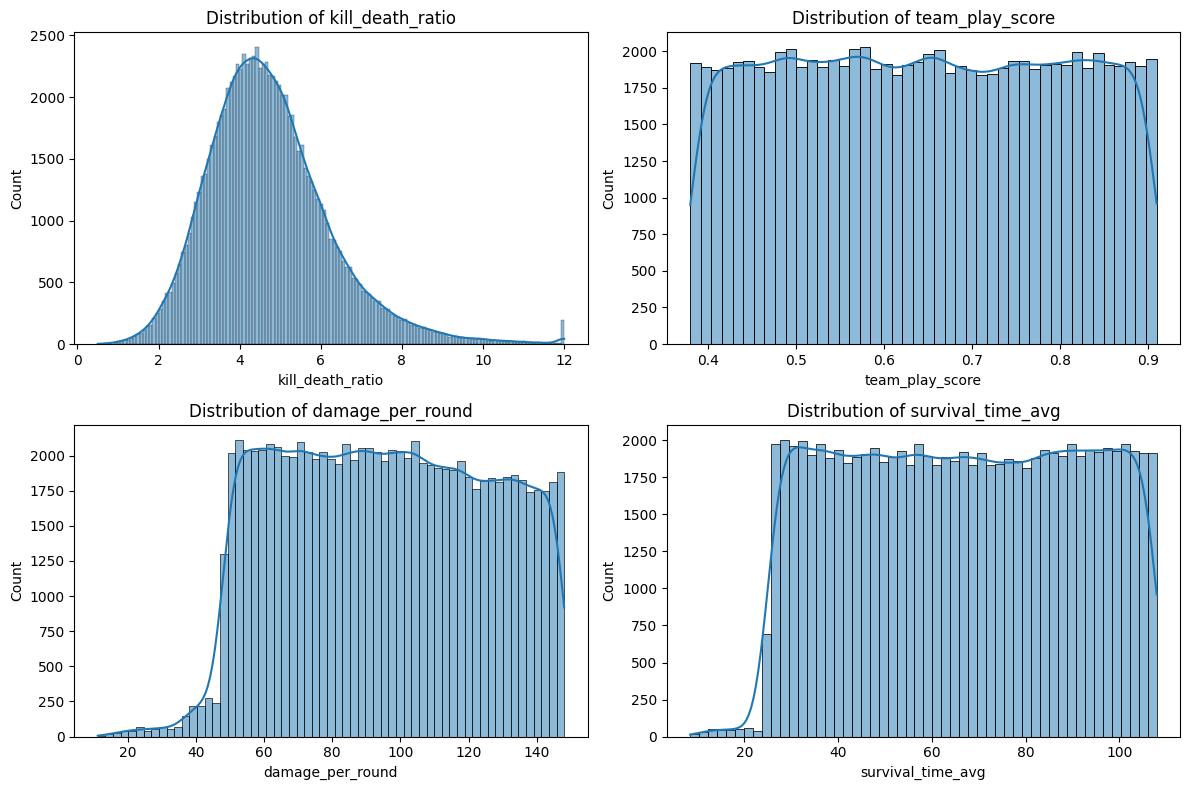

Loading data...
== train shape: (99872, 34)
         id player_id  kill_death_ratio  headshot_percentage   win_rate  \
0  PLY00001   P058048          4.556072            15.494589        NaN   
1  PLY00002   P037400          6.177695            51.476210  86.670187   
2  PLY00003   P001054          6.584511            51.692578  32.827778   
3  PLY00004   P062710          5.237014            44.181842  62.740475   
4  PLY00005   P068548          2.453744            44.361101  68.296046   

   accuracy_score  kill_consistency  reaction_time_ms  account_age_days  \
0       36.953785          0.737653               NaN       1204.586641   
1       59.946064               NaN         93.748524          3.405453   
2       46.545739          0.811803        120.895839        551.221686   
3       30.260066          0.345491        248.056545        114.034430   
4       27.470153          0.851962        210.530688        153.210944   

       level  ...  team_play_score  buy_decision_score

[I 2025-11-28 12:05:19,268] A new study created in memory with name: no-name-8cd562b8-3f62-4351-93f4-cdb9a46d07e2


Best params (fold): {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Default threshold report:
              precision    recall  f1-score   support

         0.0     0.8900    0.7119    0.7910     12723
         1.0     0.6089    0.8361    0.7046      6826

    accuracy                         0.7552     19549
   macro avg     0.7495    0.7740    0.7478     19549
weighted avg     0.7919    0.7552    0.7609     19549

Best threshold by F2: 0.310 (F2=0.8298)
Tuned threshold 0.310 (F2=0.8298)
              precision    recall  f1-score   support

         0.0     0.9728    0.5233    0.6805     12723
         1.0     0.5226    0.9728    0.6799      6826

    accuracy                         0.6802     19549
   macro avg     0.7477    0.7480    0.6802     19549
weighted avg     0.8156    0.6802    0.6803     19549

Best threshold by F2: 0.276 (F2=0.8258)


[I 2025-11-28 12:13:41,962] Trial 0 finished with value: 0.8203111539283656 and parameters: {'n_estimators': 363, 'max_depth': 7, 'learning_rate': 0.17051514974326454, 'subsample': 0.876928784817278, 'colsample_bytree': 0.8611509581513122, 'min_child_weight': 10, 'gamma': 0.48847484788897844, 'scale_pos_weight': 3.126702701175466}. Best is trial 0 with value: 0.8203111539283656.
[I 2025-11-28 12:22:14,756] Trial 1 finished with value: 0.8198117676844632 and parameters: {'n_estimators': 496, 'max_depth': 4, 'learning_rate': 0.14596135085213294, 'subsample': 0.6103618085533877, 'colsample_bytree': 0.9775540495322906, 'min_child_weight': 10, 'gamma': 0.0034132904774665795, 'scale_pos_weight': 2.4533027909442584}. Best is trial 0 with value: 0.8203111539283656.
[I 2025-11-28 12:30:39,497] Trial 2 finished with value: 0.8223601810571192 and parameters: {'n_estimators': 673, 'max_depth': 3, 'learning_rate': 0.19724515947976756, 'subsample': 0.6604617878442751, 'colsample_bytree': 0.690626879

Best params: {'n_estimators': 673, 'max_depth': 3, 'learning_rate': 0.19724515947976756, 'subsample': 0.6604617878442751, 'colsample_bytree': 0.6906268793255508, 'min_child_weight': 1, 'gamma': 0.008490336807103593, 'scale_pos_weight': 4.140030849531947}
Best F2: 0.8223601810571192
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8204
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027610 seconds.
You can set `force_col_wise=true` to remove the 

In [20]:
import os
import warnings
import lightgbm as lgb
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer, classification_report, precision_recall_curve

import optuna
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import joblib

# ----------------------------- Config -----------------------------
#DATA_DIR = "task1"
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
DATACARD_PATH = "datacard.txt"
OUTPUT_PRED_CSV = "task1.4.csv"
MODEL_OUTPUT = "cheater_xgb_model1_4.joblib"
RANDOM_STATE = 42
N_FOLDS = 5
USE_SMOTE = True  # toggle this if you prefer class-weighting approach

# ----------------------------- EDA -----------------------------
key_metrics = ["kill_death_ratio", "team_play_score", "damage_per_round", "survival_time_avg"]

# Plot distribution of features
plt.figure(figsize=(12, 8))
for i, col in enumerate(key_metrics, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# -------------------------- Utility funcs -------------------------

def load_data(train_path=TRAIN_PATH, test_path=TEST_PATH):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test


def basic_report(df, name="data"):
    print(f"== {name} shape: {df.shape}")
    print(df.head())
    print(df.isna().sum().sort_values(ascending=False).head(10))

# ---------------------- Feature engineering ------------------------

def add_engineered_features(df):
    # Defensive copies
    df = df.copy()

    # Fill missing temporarily for ratio operations
    eps = 1e-6


    if "accuracy_time_ms" in df.columns and "reaction_time_ms" in df.columns:
        df["precision_speed"] = df["accuracy_time_ms"] / (df["reaction_time_ms"] + eps)

    if "kill_death_ratio" in df.columns and "headshot_percentage" in df.columns:
        df["aggressive_efficiency"] = df["kill_death_ratio"] * df["headshot_percentage"]

    if "game_sense" in df.columns and "accuracy_score" in df.columns:
        df["skill_consistency"] = df["game_sense"] / (df["accuracy_score"] + eps)

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # exclude target if present
    num_cols = [c for c in num_cols if c != "is_cheater"]
    if len(num_cols) >= 3:
        df["numeric_mean"] = df[num_cols].mean(axis=1)
        df["numeric_std"] = df[num_cols].std(axis=1).fillna(0.0)

    return df

# -------------------------- Preprocessing -------------------------

def build_preprocessing_pipeline(numeric_cols):
    # Imputer -> scaler
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    def fit_transform(X):
        X_imputed = imputer.fit_transform(X)
        X_scaled = scaler.fit_transform(X_imputed)
        return X_imputed, X_scaled, imputer, scaler

    return imputer, scaler



# ------------------------- Model & CV -----------------------------

def cross_validate_train(X, y, use_smote=USE_SMOTE, random_state=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    # baseline XGBoost classifier
    model = XGBClassifier(
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=random_state,
        n_jobs=-1,
        deterministic=True
    )

    # hyperparameter grid
    param_grid = {
        "n_estimators": [200],
        "max_depth": [4, 6],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8],
        "colsample_bytree": [0.8],
    }

    f2_scorer = make_scorer(fbeta_score, beta=2)


    oof_preds = np.zeros(len(X))
    best_models = []
    fold_idx = 0

    for train_idx, valid_idx in skf.split(X, y):
        fold_idx += 1
        print(f"\n--- Fold {fold_idx}/{N_FOLDS} ---")
        X_tr, X_val = X[train_idx], X[valid_idx]
        y_tr, y_val = y[train_idx], y[valid_idx]

        if use_smote:
            sm = SMOTE(random_state=random_state)
            X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
            print(f"SMOTE applied: new train distribution: {np.bincount(y_tr.astype(int))}")

        grid = GridSearchCV(model, param_grid, scoring=f2_scorer, cv=3, n_jobs=-1, verbose=0)
        grid.fit(X_tr, y_tr)
        best = grid.best_estimator_
        print("Best params (fold):", grid.best_params_)

        val_probs = best.predict_proba(X_val)[:, 1]
        oof_preds[valid_idx] = val_probs
        best_models.append(best)

        val_pred_default = (val_probs >= 0.5).astype(int)
        print("Default threshold report:")
        print(classification_report(y_val, val_pred_default, digits=4))

        fold_t, fold_f2 = tune_threshold(y_val, val_probs)
        val_pred_tuned = (val_probs >= fold_t).astype(int)
        print(f"Tuned threshold {fold_t:.3f} (F2={fold_f2:.4f})")
        print(classification_report(y_val, val_pred_tuned, digits=4))


    return oof_preds, best_models

# ---------------------- Threshold tuning --------------------------

def tune_threshold(y_true, prob_preds):
    precision, recall, thresholds = precision_recall_curve(y_true, prob_preds)
    f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-9)
    best_idx = np.argmax(f2_scores)
    best_t = thresholds[best_idx]
    best_f2 = f2_scores[best_idx]

    print(f"Best threshold by F2: {best_t:.3f} (F2={best_f2:.4f})")
    return best_t, best_f2

# ------------------------- Ensembling -----------------------------

def ensemble_predict(models, X):
    # average predicted probabilities
    probs = np.mean([m.predict_proba(X)[:, 1] for m in models], axis=0)
    return probs


def objective(trial, X, y, use_smote=True, sampler="SMOTE"):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[valid_idx]
        y_tr, y_val = y[train_idx], y[valid_idx]

        if use_smote:
            if sampler == "SMOTE":
                sm = SMOTE(random_state=42)
            elif sampler == "SMOTEENN":
                sm = SMOTEENN(random_state=42)
            elif sampler == "ADASYN":
                sm = ADASYN(random_state=42)
            X_tr, y_tr = sm.fit_resample(X_tr, y_tr)

        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "random_state": 42,
            "n_estimators": trial.suggest_int("n_estimators", 200, 800),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 0.5),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),
        }

        model = XGBClassifier(**params, n_jobs=-1)
        model.fit(X_tr, y_tr)
        val_probs = model.predict_proba(X_val)[:, 1]
        oof_preds[valid_idx] = val_probs

    # Tune threshold globally
    precision, recall, thresholds = precision_recall_curve(y, oof_preds)
    f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-9)
    best_idx = np.argmax(f2_scores)
    return f2_scores[best_idx]


# Run Optuna
def run_optuna(X, y, sampler="SMOTE"):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X, y, sampler=sampler), n_trials=3)
    print("Best params:", study.best_params)
    print("Best F2:", study.best_value)
    return study.best_params


def train_lightgbm(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[valid_idx]
        y_tr, y_val = y[train_idx], y[valid_idx]

        train_data = lgb.Dataset(X_tr, label=y_tr)
        valid_data = lgb.Dataset(X_val, label=y_val)

        params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "boosting_type": "gbdt",
            "learning_rate": 0.05,
            "num_leaves": 31,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "scale_pos_weight": np.sum(y_tr==0)/np.sum(y_tr==1),
        }

        model = lgb.train(params, train_data, valid_sets=[valid_data])
        val_probs = model.predict(X_val)
        oof_preds[valid_idx] = val_probs

    # Threshold tuning
    precision, recall, thresholds = precision_recall_curve(y, oof_preds)
    f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-9)
    best_idx = np.argmax(f2_scores)
    print(f"Best threshold {thresholds[best_idx]:.3f}, F2={f2_scores[best_idx]:.4f}")
    return model


# --------------------------- Main --------------------------------

def main():
    print("Loading data...")
    train, test = load_data()
    basic_report(train, "train")
    basic_report(test, "test")

    if "is_cheater" not in train.columns:
        raise ValueError("Train CSV must contain 'is_cheater' target column")

    train["is_cheater"] = pd.to_numeric(train["is_cheater"], errors="coerce")
    train = train.dropna(subset=["is_cheater"])

    y = train["is_cheater"].values
    X = train.drop(columns=["is_cheater"]).copy()

    X = add_engineered_features(X)
    test_fe = add_engineered_features(test)

    shared_cols = [c for c in X.columns if c in test_fe.columns]
    X = X[shared_cols]
    test_fe = test_fe[shared_cols]


    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X_num = X[numeric_cols].values
    test_num = test_fe[numeric_cols].values

    print(f"Using numeric features: {len(numeric_cols)} columns")

    # Preprocessing: imputation + scaling
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    X_imputed = imputer.fit_transform(X_num)
    X_scaled = scaler.fit_transform(X_imputed)

    test_imputed = imputer.transform(test_num)
    test_scaled = scaler.transform(test_imputed)

    oof_probs, models = cross_validate_train(X_scaled, y, use_smote=USE_SMOTE)

    best_threshold, best_f2 = tune_threshold(y, oof_probs)

    best_params = run_optuna(X_scaled, y, sampler="SMOTEENN")
    xgb_model = XGBClassifier(**best_params, n_jobs=-1)
    xgb_model.fit(X_scaled, y)

    lgb_model = train_lightgbm(X_scaled, y)

    test_probs = xgb_model.predict_proba(test_scaled)[:, 1]
    test_pred_labels = (test_probs >= 0.5).astype(int)

    if "id" in test.columns:
        out_ids = test["id"].values
    else:
        out_ids = np.arange(len(test))

    out_df = pd.DataFrame({
        "id": out_ids,
        "task1": test_pred_labels,
    })

    out_df.to_csv(OUTPUT_PRED_CSV, index=False)
    print(f"Predictions saved to: {OUTPUT_PRED_CSV}")

    # Save one of the trained models (first model) and preprocessors
    joblib.dump(
        {
            "models": models,
            "imputer": imputer,
            "scaler": scaler,
            "threshold": best_threshold,
        },
        MODEL_OUTPUT,
    )
    print(f"Model and artifacts saved to: {MODEL_OUTPUT}")

    # Final local report on OOF
    print("\nFinal OOF F2:")
    oof_pred_labels = (oof_probs >= best_threshold).astype(int)
    print("F2:", fbeta_score(y, oof_pred_labels, beta=2))
    print(classification_report(y, oof_pred_labels, digits=4))

if __name__ == "__main__":
    main()





**Evaluation & Result**


--- Fold 1/5 ---
SMOTE applied: new train distribution: [50895 50895]
Best params (fold): {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Default threshold report:
              precision    recall  f1-score   support

         0.0     0.8851    0.7059    0.7854     12724
         1.0     0.6020    0.8292    0.6976      6826

    accuracy                         0.7490     19550
   macro avg     0.7436    0.7675    0.7415     19550
weighted avg     0.7863    0.7490    0.7547     19550

Best threshold by F2: 0.257 (F2=0.8271)
Tuned threshold 0.257 (F2=0.8271)
              precision    recall  f1-score   support

         0.0     0.9833    0.4804    0.6455     12724
         1.0     0.5042    0.9848    0.6669      6826

    accuracy                         0.6565     19550
   macro avg     0.7437    0.7326    0.6562     19550
weighted avg     0.8160    0.6565    0.6530     19550


--- Fold 2/5 ---
SMOTE applied: new train distribu

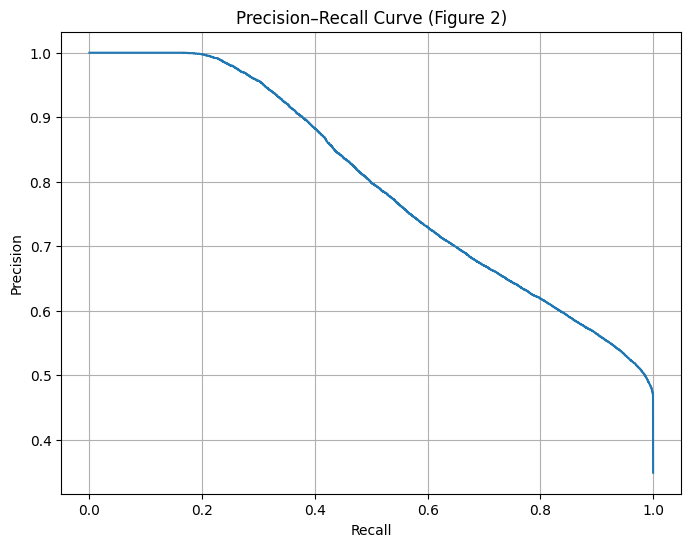

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

train, _ = load_data()

train["is_cheater"] = pd.to_numeric(train["is_cheater"], errors="coerce")
train = train.dropna(subset=["is_cheater"])
y_true = train["is_cheater"].values
X = train.drop(columns=["is_cheater"]).copy()

X = add_engineered_features(X)

_, test_df_for_cols = load_data(test_path=TEST_PATH)
test_fe_for_cols = add_engineered_features(test_df_for_cols)
shared_cols = [c for c in X.columns if c in test_fe_for_cols.columns]
X = X[shared_cols]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_num = X[numeric_cols].values

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X_num)
X_scaled = scaler.fit_transform(X_imputed)

y_pred_proba, _ = cross_validate_train(X_scaled, y_true, use_smote=USE_SMOTE)

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Figure 2)")
plt.grid(True)
plt.show()

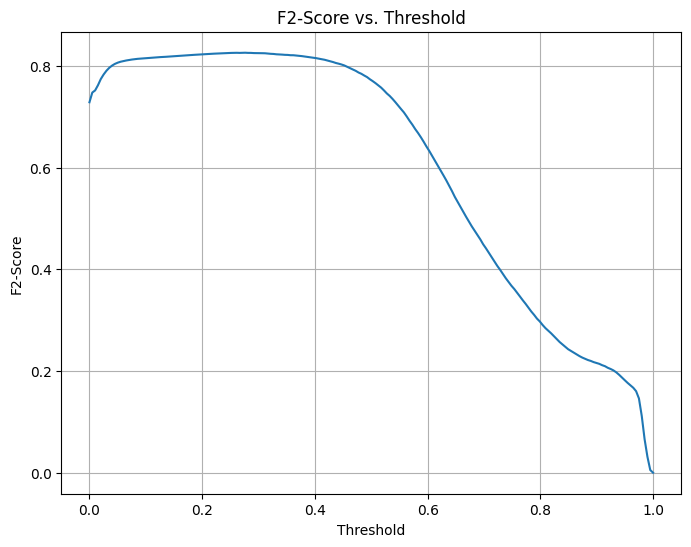

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

thresholds = np.linspace(0, 1, 200)
f2_scores = []

for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    f2 = fbeta_score(y_true, preds, beta=2)
    f2_scores.append(f2)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f2_scores)
plt.xlabel("Threshold")
plt.ylabel("F2-Score")
plt.title("F2-Score vs. Threshold")
plt.grid(True)
plt.show()


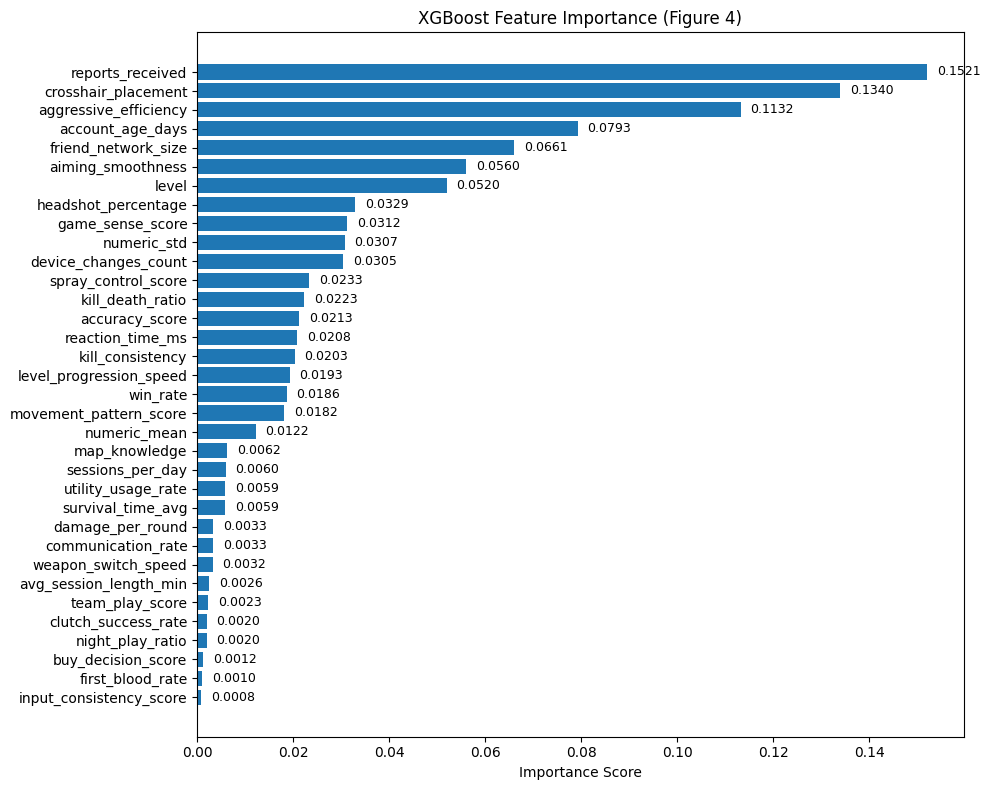

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

artifacts = joblib.load("cheater_xgb_model1_4.joblib")

model = artifacts["models"][0]

train = pd.read_csv("train.csv")
X = train.drop(columns=["is_cheater"])

X = add_engineered_features(X)

feature_names = X.select_dtypes(include=[np.number]).columns.tolist()

importance = model.feature_importances_

df_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 8))
bars = plt.barh(df_imp["feature"], df_imp["importance"])
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importance (Figure 4)")
plt.gca().invert_yaxis()

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.002,
        bar.get_y() + bar.get_height()/2,
        f"{width:.4f}",
        va='center', fontsize=9
    )

plt.tight_layout()
plt.show()
